In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from value import Value
import random
from typing import Sequence


In [2]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # create a node
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # create an op node
            dot.node(name=uid + n._op, label=n._op)
            # connect the op node to the value node
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [3]:
a=Value(-4.0, label='a')
b=Value(2.0, label='b')
c=a/b; c.label='c'

In [4]:
c.backward()

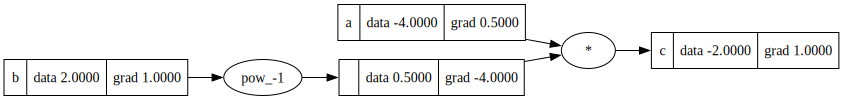

In [5]:
draw_dot(c)

# Neuron Imitation

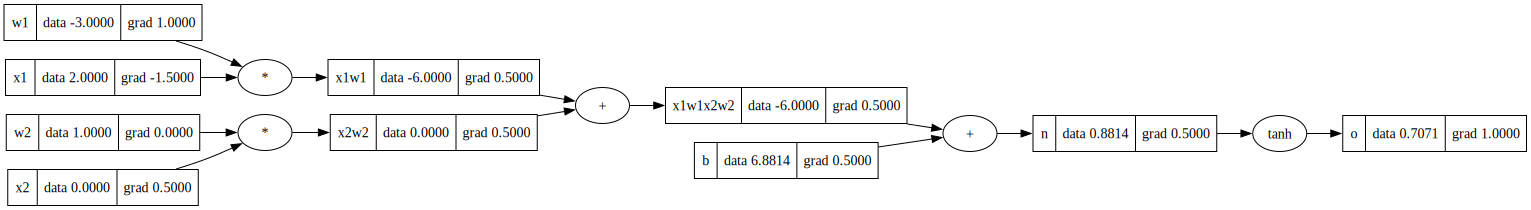

In [6]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)

# Using Pytorch

In [10]:
import torch

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.8813735870195432, requires_grad=True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())


0.7071067094802856
---
x1 -1.5000003576278687
w1 1.000000238418579
x2 0.5000001192092896
w2 0.0


# Neuron Class

In [ ]:
class Neuron(object):
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x: Sequence[Value|float|int]) -> Value:
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out


In [ ]:
class Layer(object):
    def __init__(self, nin: int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x: Sequence[Value|float|int]) -> Sequence[Value|float|int] | Value:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs


In [ ]:
class MLP(object):
    def __init__(self, nin: int, nouts: list[int]):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x: Sequence[Value|float|int]) -> Sequence[Value|float|int] | Value:
        y: Sequence[Value|float|int] = x
        out: Sequence[Value|float|int] | Value | float | int = x
        for i, layer in enumerate(self.layers):
            out = layer(y)
            if isinstance(out, Sequence):
                y = out
            elif i < len(self.layers) - 1:
                y = [out]
        return out


In [20]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7024812393487738, grad=0.0)

## Example Dataset

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

ypred

[Value(data=0.7024812393487738, grad=0.0),
 Value(data=0.363200248463948, grad=0.0),
 Value(data=0.629168708225027, grad=0.0),
 Value(data=0.45010547513587384, grad=0.0)]

In [28]:
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.903406998686758, grad=0.0)

In [ ]:
loss.backward()